In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as  plt

import torch


# Importing modules from src 
# (some modules have their own deprendencies that are being imported by paths, relative to themselfes, so there is need to add more folders to the path, even if './../' or './../src' were already added)
import os
import sys
sys.path.append(os.path.abspath('./..'))
sys.path.append(os.path.abspath('./../src'))
sys.path.append(os.path.abspath('./../src/data_preprocessing'))
sys.path.append(os.path.abspath('./../src/architectures'))

# Data processing
from torch.utils.data import DataLoader
from data_preprocessing.custom_preprocess import custom_preprocess
from data_preprocessing.custom_dataset import CustomDataset
from data_preprocessing.load_cached_or_preprocess_and_cache import load_cached_or_preprocess_and_cache


from utils.live_plot import LivePlot

In [2]:
device = 'cuda'
torch.manual_seed(42)

# Preprocess data

In [3]:
df = pd.read_csv('./../sampled_df.csv')

### Loading cached, already vectorized text_matrices
* or if at least 1 of them is not cached - then reprocess and recache
* you can choose whether to use caching or not by just changing value of USE_CACHING variable
* caching is very useful because each time when you restart kernel u need to process data again, it take some time. But if you will just cache them once and load whenever u need, it will be much faster and easier
* If you resampled your data, then you can just manually delete folder with old cached subsets, then the function will not find files and then process and cache ur new data

In [4]:
USE_PREPROCESSED_SUBSETS_CACHING = True


folder = './../cached_subsets/'


if USE_PREPROCESSED_SUBSETS_CACHING:
    X_train, X_dev, X_test, y_train, y_dev, y_test = load_cached_or_preprocess_and_cache(df, folder)

else:
    X_train, X_dev, X_test, y_train, y_dev, y_test = custom_preprocess(df, dev_size=0.15, test_size=0.15, even_dist=True)

All cached subsets were found, loading...
Loaded!


In [5]:
for subset in [X_train, X_dev, X_test, y_train, y_dev, y_test]:
  print(subset.shape)
  print(subset.dtype)

torch.Size([49000, 300, 373])
torch.float32
torch.Size([10500, 300, 373])
torch.float32
torch.Size([10500, 300, 373])
torch.float32
torch.Size([49000, 1])
torch.float32
torch.Size([10500, 1])
torch.float32
torch.Size([10500, 1])
torch.float32


### Check distributions

In [6]:
%matplotlib inline

Text(0.5, 1.0, 'Label distribution in train set')

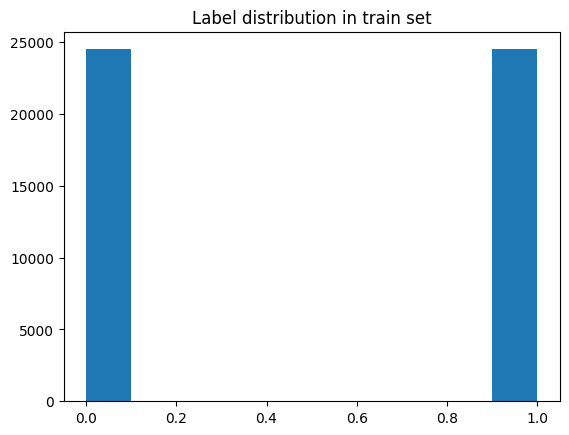

In [7]:
plt.hist(y_train.reshape(-1).cpu())
plt.title('Label distribution in train set')

Text(0.5, 1.0, 'Label distribution in dev set')

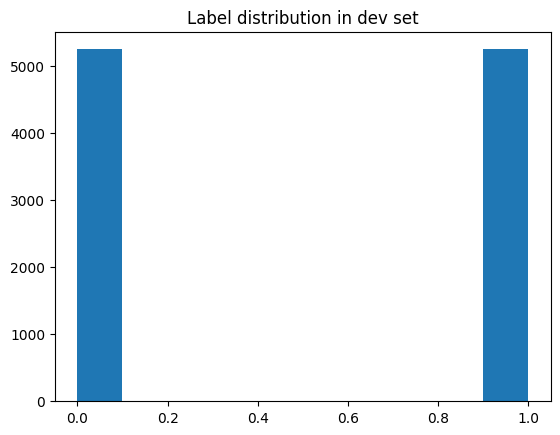

In [8]:
plt.hist(y_dev.reshape(-1).cpu())
plt.title('Label distribution in dev set')

Text(0.5, 1.0, 'Label distribution in test set')

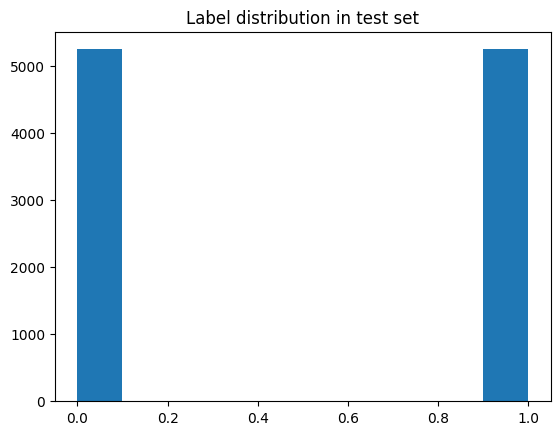

In [9]:
plt.hist(y_test.reshape(-1).cpu())
plt.title('Label distribution in test set')

### Making dataloaders

In [10]:
train_ds = CustomDataset(X_train, y_train)
dev_ds = CustomDataset(X_dev, y_dev)
test_ds = CustomDataset(X_test, y_test)

batch_size = 64

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False, drop_last=True)
dev_dl = DataLoader(dev_ds, batch_size=batch_size, shuffle=False, drop_last=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=True)


# That is how many examples are used now(truncated because of drop_last=True)
len(y_train) // batch_size * batch_size, len(y_dev) // batch_size * batch_size

(48960, 10496)

In [11]:
len(train_dl), len(dev_dl), len(test_dl)

(765, 164, 164)

In [12]:
input_channels = X_train.shape[1]
input_width = X_train.shape[2]
output_size = 1

# Train

In [13]:
from train_fn import train

### Model 1 - linear

In [14]:
from architectures.paral_conv_linear_arch1 import Parallel1DConvsLinearClass

In [26]:
model_1 = Parallel1DConvsLinearClass(
  input_channels=input_channels,
  kernel_sizes=[3, 4, 5, 6],
  out_channels_per_kernel=128,
  linear_hidden_sizes=[512, 512, 1]
).to(device)

train_loss_history = []
dev_loss_history = []



print('Number of parameters:')
print(torch.nn.utils.parameters_to_vector(model_1.parameters()).numel())

Number of parameters:
1217537


In [27]:
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.0001, weight_decay=0.05)

In [28]:
plt.close()
%matplotlib qt 
live_plot = LivePlot(slice_prop=0.2)

In [31]:
epochs = 1

train_loss_history, dev_loss_history = train(
# train_loss_history = train(
    model=model_1,
    train_dl=train_dl,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=epochs,
    dev_dl=dev_dl,
    device=device,
    tr_loss_hist=train_loss_history,
    dev_loss_hist=dev_loss_history,
    live_plot=live_plot
)

Epoch 12 results (#1 in this launch)
Train: loss = 0.09492773575574355; accuracy = 97.418 %
Dev: loss = 0.15963801307740008; accuracy = 93.969 %
------------


# Test

In [32]:
from test_fn import test

In [33]:
test(model=model_1, 
     dataloaders=[train_dl, dev_dl, test_dl], 
     loss_fn=loss_fn, 
     model_device=device)

Train
Loss: 0.09492773565104584 Accuracy: 97.418 %
------------
Dev
Loss: 0.15963801041972348 Accuracy: 93.969 %
------------
Test
Loss: 0.1762202772788885 Accuracy: 93.045 %
------------


# Experiments histroy (bin)

* Epoch 555 started (#555 in this launch)
Train: loss = 0.4425268841039448; accuracy = 89.06 %
Dev: loss = 0.4583001514760459; accuracy = 87.91 %

* Epoch 100 started
Train: loss = 0.35257; accuracy = 99.083%
Dev: loss = 0.63382; accuracy = 80.367 %
(weight_decay = 0, lr=0.000005)
* Epoch 99 started
Train: loss = 0.40694; accuracy = 91.385%
Dev: loss = 0.48908; accuracy = 83.899 %
(weight_decay = 0.1, lr=0.000005)

* Epoch 344 started (344 in this launch)
Train: loss = 0.35026; accuracy = 99.455%
Dev: loss = 0.96849; accuracy = 82.473 %


41 epochs in 2 mins and 5 seconds (with batch_size=128) error=0.466

64 filters pre kernel  = 0.35 on training set